In [161]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 
import theano
from theano import shared, tensor as tt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)
plt.style.use('classic')



In [162]:
# Data
cwd = os.chdir("/Users/ArgonLab/Documents")
df1 = pd.read_csv("Kula_Mix_Mica.csv", engine = "python")

In [163]:
df1.head()

,temp1,time1,ar391,ar401,age1,age_err1,temp2,time2,ar392,ar402,age2,age_err2,temp3,time3,ar393,ar403,age3,age_err3
0,725,12,92.06,6137.52,121.86,0.75,725,12,104.06,6223.25,108.19,0.66,725.0,12.0,109.82,5575.05,90.79,0.63
1,775,12,74.49,3128.33,131.81,0.61,775,12,101.34,3596.88,112.79,0.50,775.0,12.0,98.11,2988.19,92.66,0.52
2,820,12,185.53,7118.49,129.69,0.58,820,12,199.84,6747.15,111.24,0.49,820.0,12.0,212.02,6018.54,91.57,0.50
3,850,12,327.39,11860.89,127.00,0.57,840,12,222.71,6878.87,107.21,0.46,850.0,12.0,340.72,8783.32,90.59,0.49
4,875,12,487.57,18061.60,131.10,0.58,860,12,326.00,10333.14,111.16,0.48,875.0,12.0,493.39,13065.36,94.46,0.51


In [164]:
temp1 = df1['temp2'].values
time1 = df1['time2'].values
a391 = df1['ar392'].values
a401 = df1['ar402'].values
age1 = df1['age2'].values
age1_err = df1['age_err2'].values

In [165]:
# Shared variable for modelling 

data = age1
err = age1_err

age_err = shared(err*5)

In [166]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [167]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [168]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

In [169]:
x = 100 *frel_data(a391)

# The Age Spectra and Fractional Release Curves

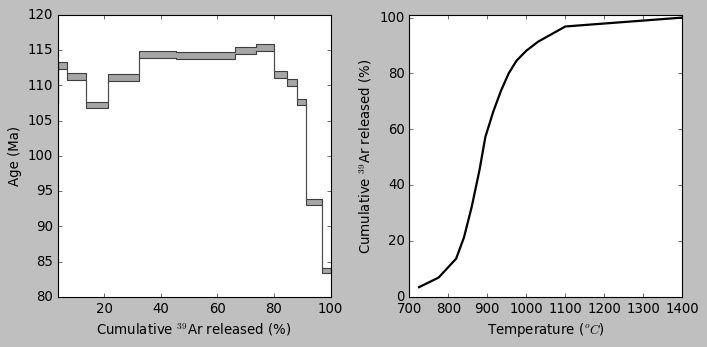

In [170]:
fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(x, data - err, data + err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(x.min(), x.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [171]:
data_f = x/100
tempk = temp1 + 273.15
t_obs = time1 * 60
N = data.shape[0]
R = 8.314e-3

(array([9.89e+03, 8.50e+01, 1.40e+01, 6.00e+00, 2.00e+00, 0.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 2.00e+00]),
 array([9.45315069e-04, 9.84560258e+00, 1.96902598e+01, 2.95349171e+01,
        3.93795744e+01, 4.92242316e+01, 5.90688889e+01, 6.89135461e+01,
        7.87582034e+01, 8.86028607e+01, 9.84475179e+01]),
 <a list of 10 Patch objects>)

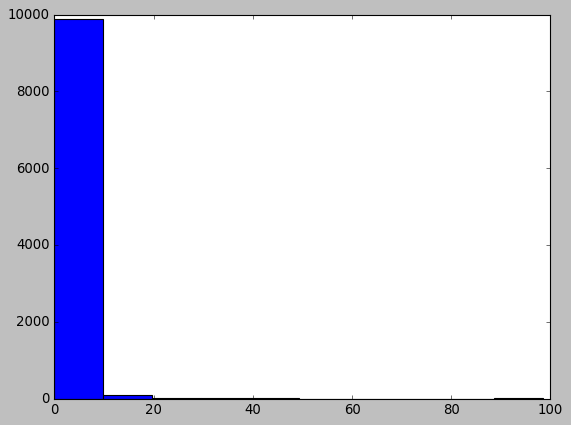

In [172]:
z = np.random.lognormal(-1, 1.4, 10000)
plt.hist(z)


In [173]:
BAr = pm.Model()
M = 1
with BAr: 
    # Volume Fraction 
    phi = pm.Dirichlet('phi', a = np.array([0.5, 0.5]), 
                      shape = 2, 
                      testval = (0.5, 0.5))
    
    phi_min = pm.Potential('phi_min', 
                          tt.switch(phi[0] < 0.43, 
                                    -np.inf,
                                   0)+ 
                          tt.switch(phi[0] > 0.57, 
                                   -np.inf,
                                   0))
    

    # Diffusion Kinetics 
    # Mineral 
    ea1 = pm.Normal('ea1', mu = 260, sd = 10)
    ea2 = pm.Normal('ea2', mu = 260, sd = 10)
    

    
    d01 = pm.Lognormal('d01', -1, 1.5)
    
    d02 = pm.Lognormal('d02', -1, 1.5)
    
    
    a1 = pm.Uniform('a1', lower = 0.001, upper = 0.0125)
    
    a2 = pm.Uniform('a2', lower = 0.001, upper = 0.0125)
    

    

In [174]:
with BAr: 
  # Deterministic
    # Cumulative Release 
    c1 = fracrelx(ea1,d01, a1, tempk, t_obs)

    c2 = fracrelx(ea2, d02, a2, tempk, t_obs)
    
    m1 = phi[0]
    
    m2 = phi[1]
    
    # Cumulative Release Model 
    
    model1 = m1*c1 + m2*c2
    
#Monotonicity
    
####################################################################################################
    for i in range(len(tempk) - 1): 
        Frel_bound_a = pm.Potential(f'f_bound_a{i}', 
                                 tt.switch(c1[i +1] - c1[i] < 0, 
                                          -np.inf, 0)) 
        Frel_bound_b = pm.Potential(f'f_bound_b{i}', 
                                 tt.switch(c2[i +1] - c2[i] < 0, 
                                          -np.inf, 0)) 

        
        
    for i in range(len(data) - 1): 
        f_con_mu = pm.Potential(f'f_bound_mu{i}', 
                               tt.switch(model1[i + 1] - model1[i] < 0, 
                                        -np.inf, 0))  
########################################################################################################
     
    

In [175]:
with BAr: 
    
    # Incremental Curves 
    i1 = Increment(ea1, d01, a1, tempk, t_obs)
    i2 = Increment(ea2, d02, a2, tempk, t_obs)
    
    
    # Mixture Parameter
    
    phi1 = pm.Deterministic('phi1', (m1*i1)/(m1*i1 + m2*i2))
    
    phi2 = pm.Deterministic('phi2',(m2*i2)/(m1*i1 + m2*i2)) 


In [176]:
with BAr: 
    # Ages 
    age1 = pm.Uniform('age1', lower = 0.0, 
                      upper = 4600, 
                      testval = 200)
    age2 = pm.Uniform('age2', lower = 0.0, 
                      upper = 4600, 
                      testval = 100)
    
    # order potential 
    order_cons = pm.Potential('order', 
                             tt.switch(age1 - age2 < 0, 
                                      -np.inf,  0))



In [177]:
with BAr: 
    # Age Spectra Model 
    
    model2 = (phi1*age1) + (phi2*age2)

In [178]:
# Models for plotting 

with BAr: 
    f_model = pm.Deterministic('f_model', 
                               model1)
    age_model = pm.Deterministic('Age_Model', 
                                model2)

In [179]:
with BAr: 
    # Cumulative Release Error 
    f_err = pm.HalfNormal('f_err', sd = 0.1, 
                         shape = N)
    
    # Age Error 
    age_err_model = pm.HalfNormal('age_err_model', 
                                  sd = 10, 
                                 shape = N)

In [180]:
def logp(mod, data, err): 
    logp = -tt.sqr(data - mod)/(2 * err * err)
    return logp.sum()

In [181]:
with BAr: 
    # Cumulative Release Likelihood 
    L1 = pm.Normal('L1', mu = model1, sd = f_err, 
                 observed = data_f)
    


In [182]:
with BAr: 
    # Age Spectra Likelihood 

    L2 = pm.Normal('L2', mu = model2, 
                   sd = age_err_model, 
                   observed = data)
                   

In [183]:
BAr.check_test_point()

phi_stickbreaking__     -1.84
ea1                     -3.22
ea2                     -3.22
d01_log__               -1.32
d02_log__               -1.32
a1_interval__           -1.39
a2_interval__           -1.39
age1_interval__         -3.18
age2_interval__         -3.85
f_err_log__            -11.55
age_err_model_log__    -11.55
L1                    -390.55
L2                    -254.29
Name: Log-probability of test_point, dtype: float64

In [ ]:
SAMPLES = 250000
BURN = 750000


with BAr: 

    trace = pm.sample(SAMPLES, tune = BURN, 
                      step = pm.Metropolis(scaling = 0.2), 
                     chains = 2, 
                     cores = 2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [age_err_model]
>Metropolis: [f_err]
>Metropolis: [age2]
>Metropolis: [age1]
>Metropolis: [a2]
>Metropolis: [a1]
>Metropolis: [d02]
>Metropolis: [d01]
>Metropolis: [ea2]
>Metropolis: [ea1]
>Metropolis: [phi]
Sampling 2 chains:  68%|██████▊   | 1360717/2000000 [1:38:10<28:18, 376.33draws/s]  

# Traceplot

In [ ]:
sns.set_style('ticks')
pm.traceplot(trace[-1000::10]); 

# 95% Credible Interval 

In [ ]:
low1, high1 = np.percentile(trace['f_model'][-100000::2], [2.5, 97.5], axis = 0)
low2, high2 = np.percentile(trace['Age_Model'][-100000::2], [2.5, 97.5], axis = 0)

In [ ]:
low1, high1 = np.percentile(trace['f_model'][-100000::2], [2.5, 97.5], axis = 0)
low2, high2 = np.percentile(trace['Age_Model'][-100000::2], [2.5, 97.5], axis = 0)

# Mean Predictive Models
* Plot these to check the mean posterior and the deviation from data

In [234]:
Z1 = trace['f_model'][-100000::2].mean(axis = 0)
Z2 = trace['Age_Model'][-100000::2].mean(axis = 0)

# Fractional release plot

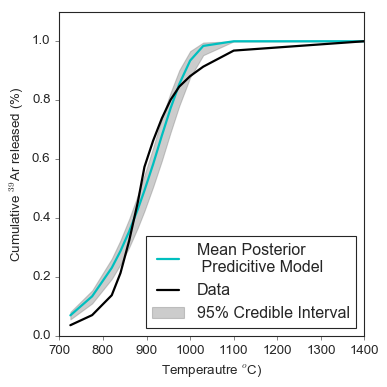

In [235]:

plt.figure(figsize = (5,5))
plt.fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
plt.plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

plt.plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
plt.ylabel('Cumulative $^{39}$Ar released (%)')
plt.xlabel('Temperautre $^{o}$C)')
plt.legend(loc = 'best')
plt.ylim(0, 1.1)
plt.tight_layout()

# Age Spectra plot

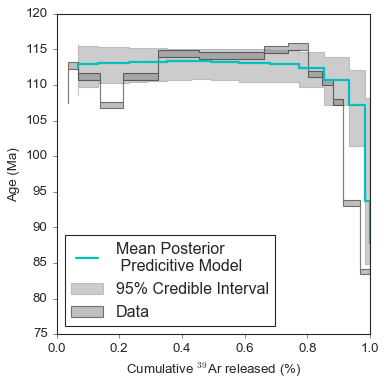

In [236]:
plt.figure(figsize = (5,5))
plt.fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval', 
                step = 'pre')
plt.plot(Z1, Z2, 'c',
         drawstyle = 'steps', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
plt.fill_between(data_f, data - err, data + err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 'best')
plt.tight_layout()

# Combined

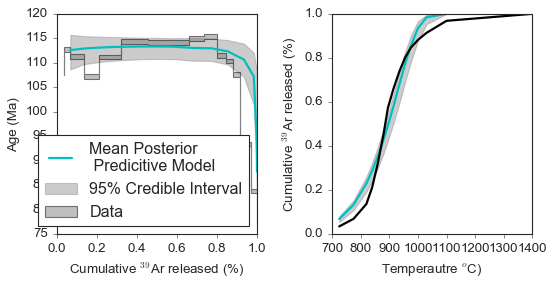

In [237]:
## AGE SPECTRA
fig, ax = plt.subplots(1,2, figsize = (7.1, 3.75))

ax[0].fill_between(Z1, low2, high2, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[0].plot(Z1, Z2, 'c', 
        lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')
ax[0].fill_between(data_f, data - err, data + err, 
                step ='pre', 
                facecolor = 'grey', 
                alpha = 0.5, 
                edgecolor = 'k', 
                label = 'Data')

ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')
ax[0].set_ylabel('Age (Ma)')
ax[0].legend(loc = 'best')



# Fractional Release
ax[1].fill_between(temp1, low1, high1, alpha = 0.4, 
                color = 'grey', 
                label = '95% Credible Interval')
ax[1].plot(temp1, Z1, 'c', lw = 2, 
        label = 'Mean Posterior \n Predicitive Model')

ax[1].plot(temp1, data_f, lw = 2, color= 'k', 
        label = 'Data')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperautre $^{o}$C)')



plt.tight_layout()

In [238]:
print(trace['age1'][-50000:].mean(axis = 0))
print(trace['age2'][-50000:].mean(axis = 0))

print(2*np.std(trace['age1'][-50000:]))
print(2*np.std(trace['age2'][-50000:]))



138.3752578254999
87.32881379389198
17.451356897901057
13.807067706802039


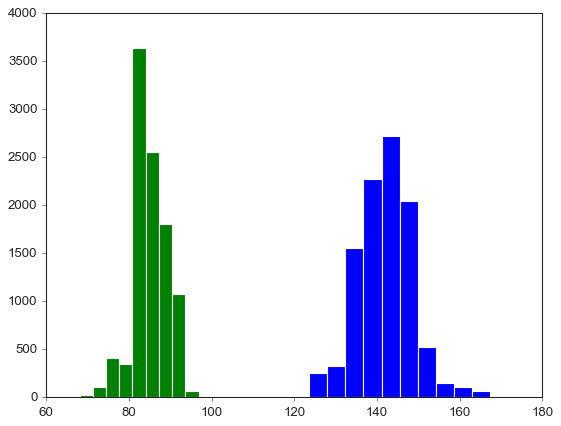

In [239]:
plt.hist(trace['age1'][-10000:].flatten()); 
plt.hist(trace['age2'][-10000:].flatten()); 

##### Log Likelihood of each Drawn Sample
* Calculation of logp for each draw in trace
* Cell below

# ml = BAr.logp
logp = [ml(i) for i in trace]

# Log Likelihood and Age trace from paper

# Save to DataFrames for plotting

In [240]:
df = pd.DataFrame({"age_model": Z2, 
                  "age_model_low": low2, 
                  "age_model_high": high2, 
                  "frel_model": Z1, 
                  "frel_model_low": low1, 
                  "frel_model_high": high1, 
                  "age_data": data, 
                  "age_err": age1_err, 
                   "frel_data": data_f, 
                  "temp": temp1})

# Trace_DataFrame
df1 = pm.trace_to_dataframe(trace[-10000::2])

In [241]:
df.to_csv('kula2_muscovite_posterior.csv')

In [242]:
df1.to_csv('kula2_muscovite_trace.csv')

In [243]:
dfp = pd.DataFrame({"age1":df1['age1'].values, 
                   "age2": df1['age2'].values, 
                    "d01":df1['d01'].values, 
                   "d02":df1['d02'].values,
                   "ea1":df1['ea1'].values, 
                   "ea2":df1['ea2'].values})

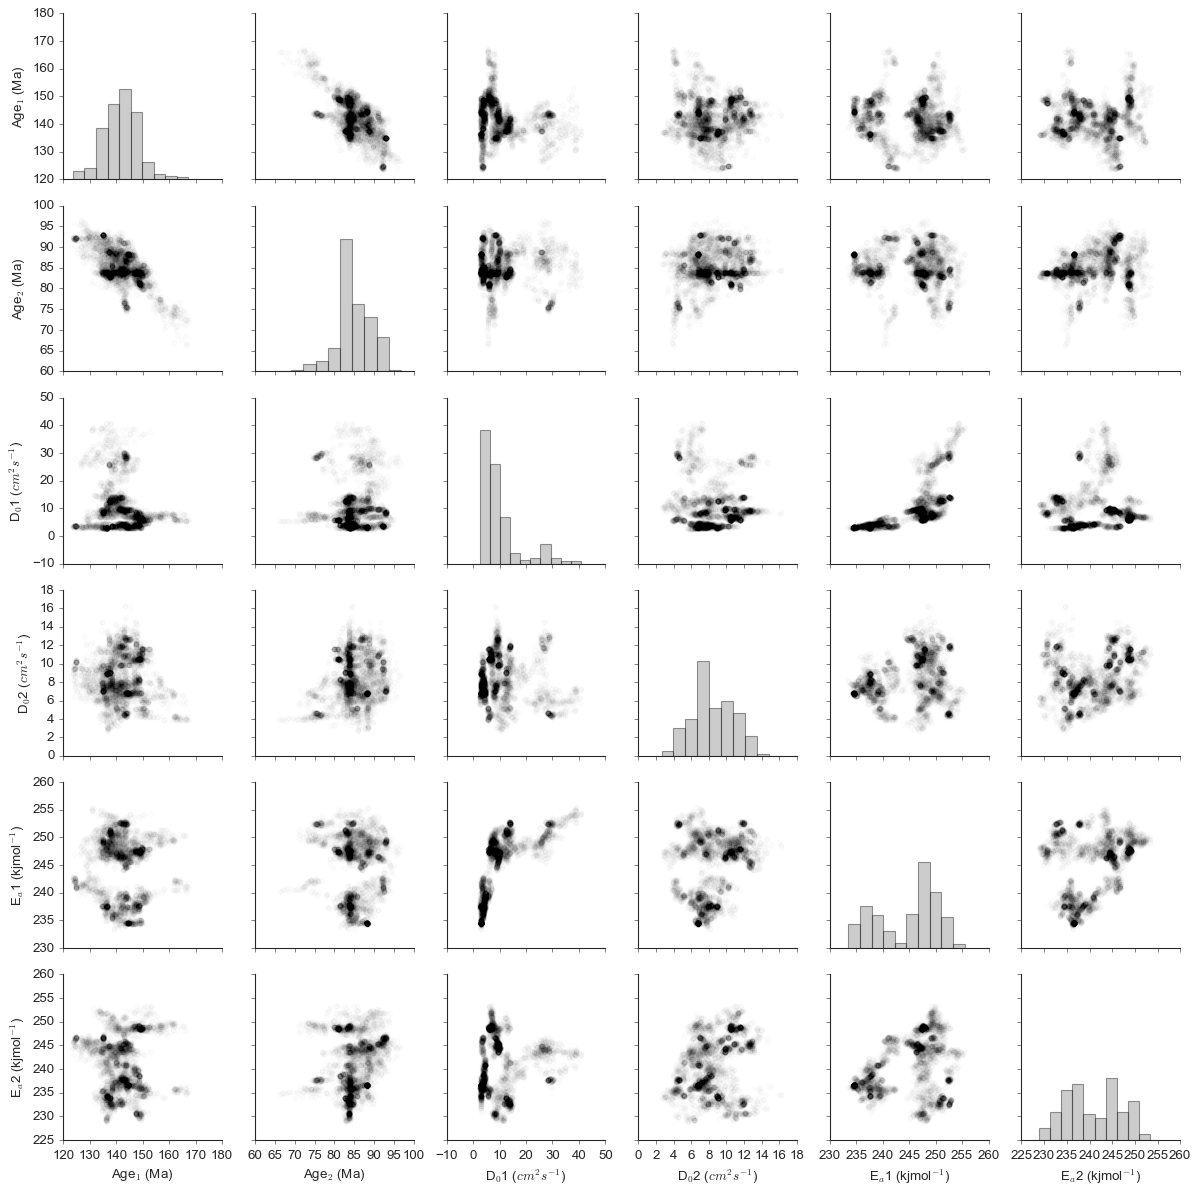

In [245]:
g = sns.PairGrid(dfp[-5000:])
g = g.map_diag(plt.hist, facecolor = 'grey', edgecolor = 'k', 
              alpha = 0.4)
g = g.map_offdiag(plt.scatter, alpha = 0.01, color = 'k')


# Y_AXIS LABELS

g.axes[0,0].set_ylabel('Age$_1$ (Ma)')
g.axes[1,0].set_ylabel('Age$_2$ (Ma)')
g.axes[2,0].set_ylabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[3,0].set_ylabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[4,0].set_ylabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,0].set_ylabel('E$_a$2 (kjmol$^{-1}$)')



# X_AXIS LABELS

g.axes[5,0].set_xlabel('Age$_1$ (Ma)')
g.axes[5,1].set_xlabel('Age$_2$ (Ma)')
g.axes[5,2].set_xlabel('D$_0$1 ($cm^{2}s^{-1}$)')
g.axes[5,3].set_xlabel('D$_0$2 ($cm^{2}s^{-1}$)')
g.axes[5,4].set_xlabel('E$_a$1 (kjmol$^{-1}$)')
g.axes[5,5].set_xlabel('E$_a$2 (kjmol$^{-1}$)');

In [122]:
dfx = dfp[-5000::4]

dfx.to_csv('kula2muscovite_final.csv')